#### <b>Objective:</b> Token Classification

#### About Dataset:
*  <b>Dataset:</b> [FUNSD - Form Understanding in Noisy Scanned Documents](https://guillaumejaume.github.io/FUNSD/) <br>
FUNSD paper: https://arxiv.org/abs/1905.13538
 * The dataset comprises 199 real, fully annotated, scanned forms.
 *  Labels:
    1.   question
    2.   answer
    3.   header
    4.   other

## Install Necesities

##### Library introduction:
1.   unilm -  **Uni**fied pre-trained **L**anguage **M**odel:
        * for pre-processing
        * also includes layoutlm model

2.  Transformer
      * Here, we're cloning it separately so that it can update the outdated transformers package that is included in the unilm package.

In [1]:
# ! rm -r unilm
# ! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git
# ! cd unilm/layoutlm
# ! pip install unilm/layoutlm

In [2]:
# ! rm -r transformers
# ! git clone https://github.com/huggingface/transformers.git
# ! cd transformers
# ! pip install ./transformers

#### View image with annotations

#### Json understanding:
It includes coordinates with corresponding labels. Further, it also includes sub words that are added inside that particular label.
example:

qip.in is labeled as other.
so json contains, overall bounding box co-ordinates for qip.in. And addition to that it also contains co-ordinates for qip, . and in separately.

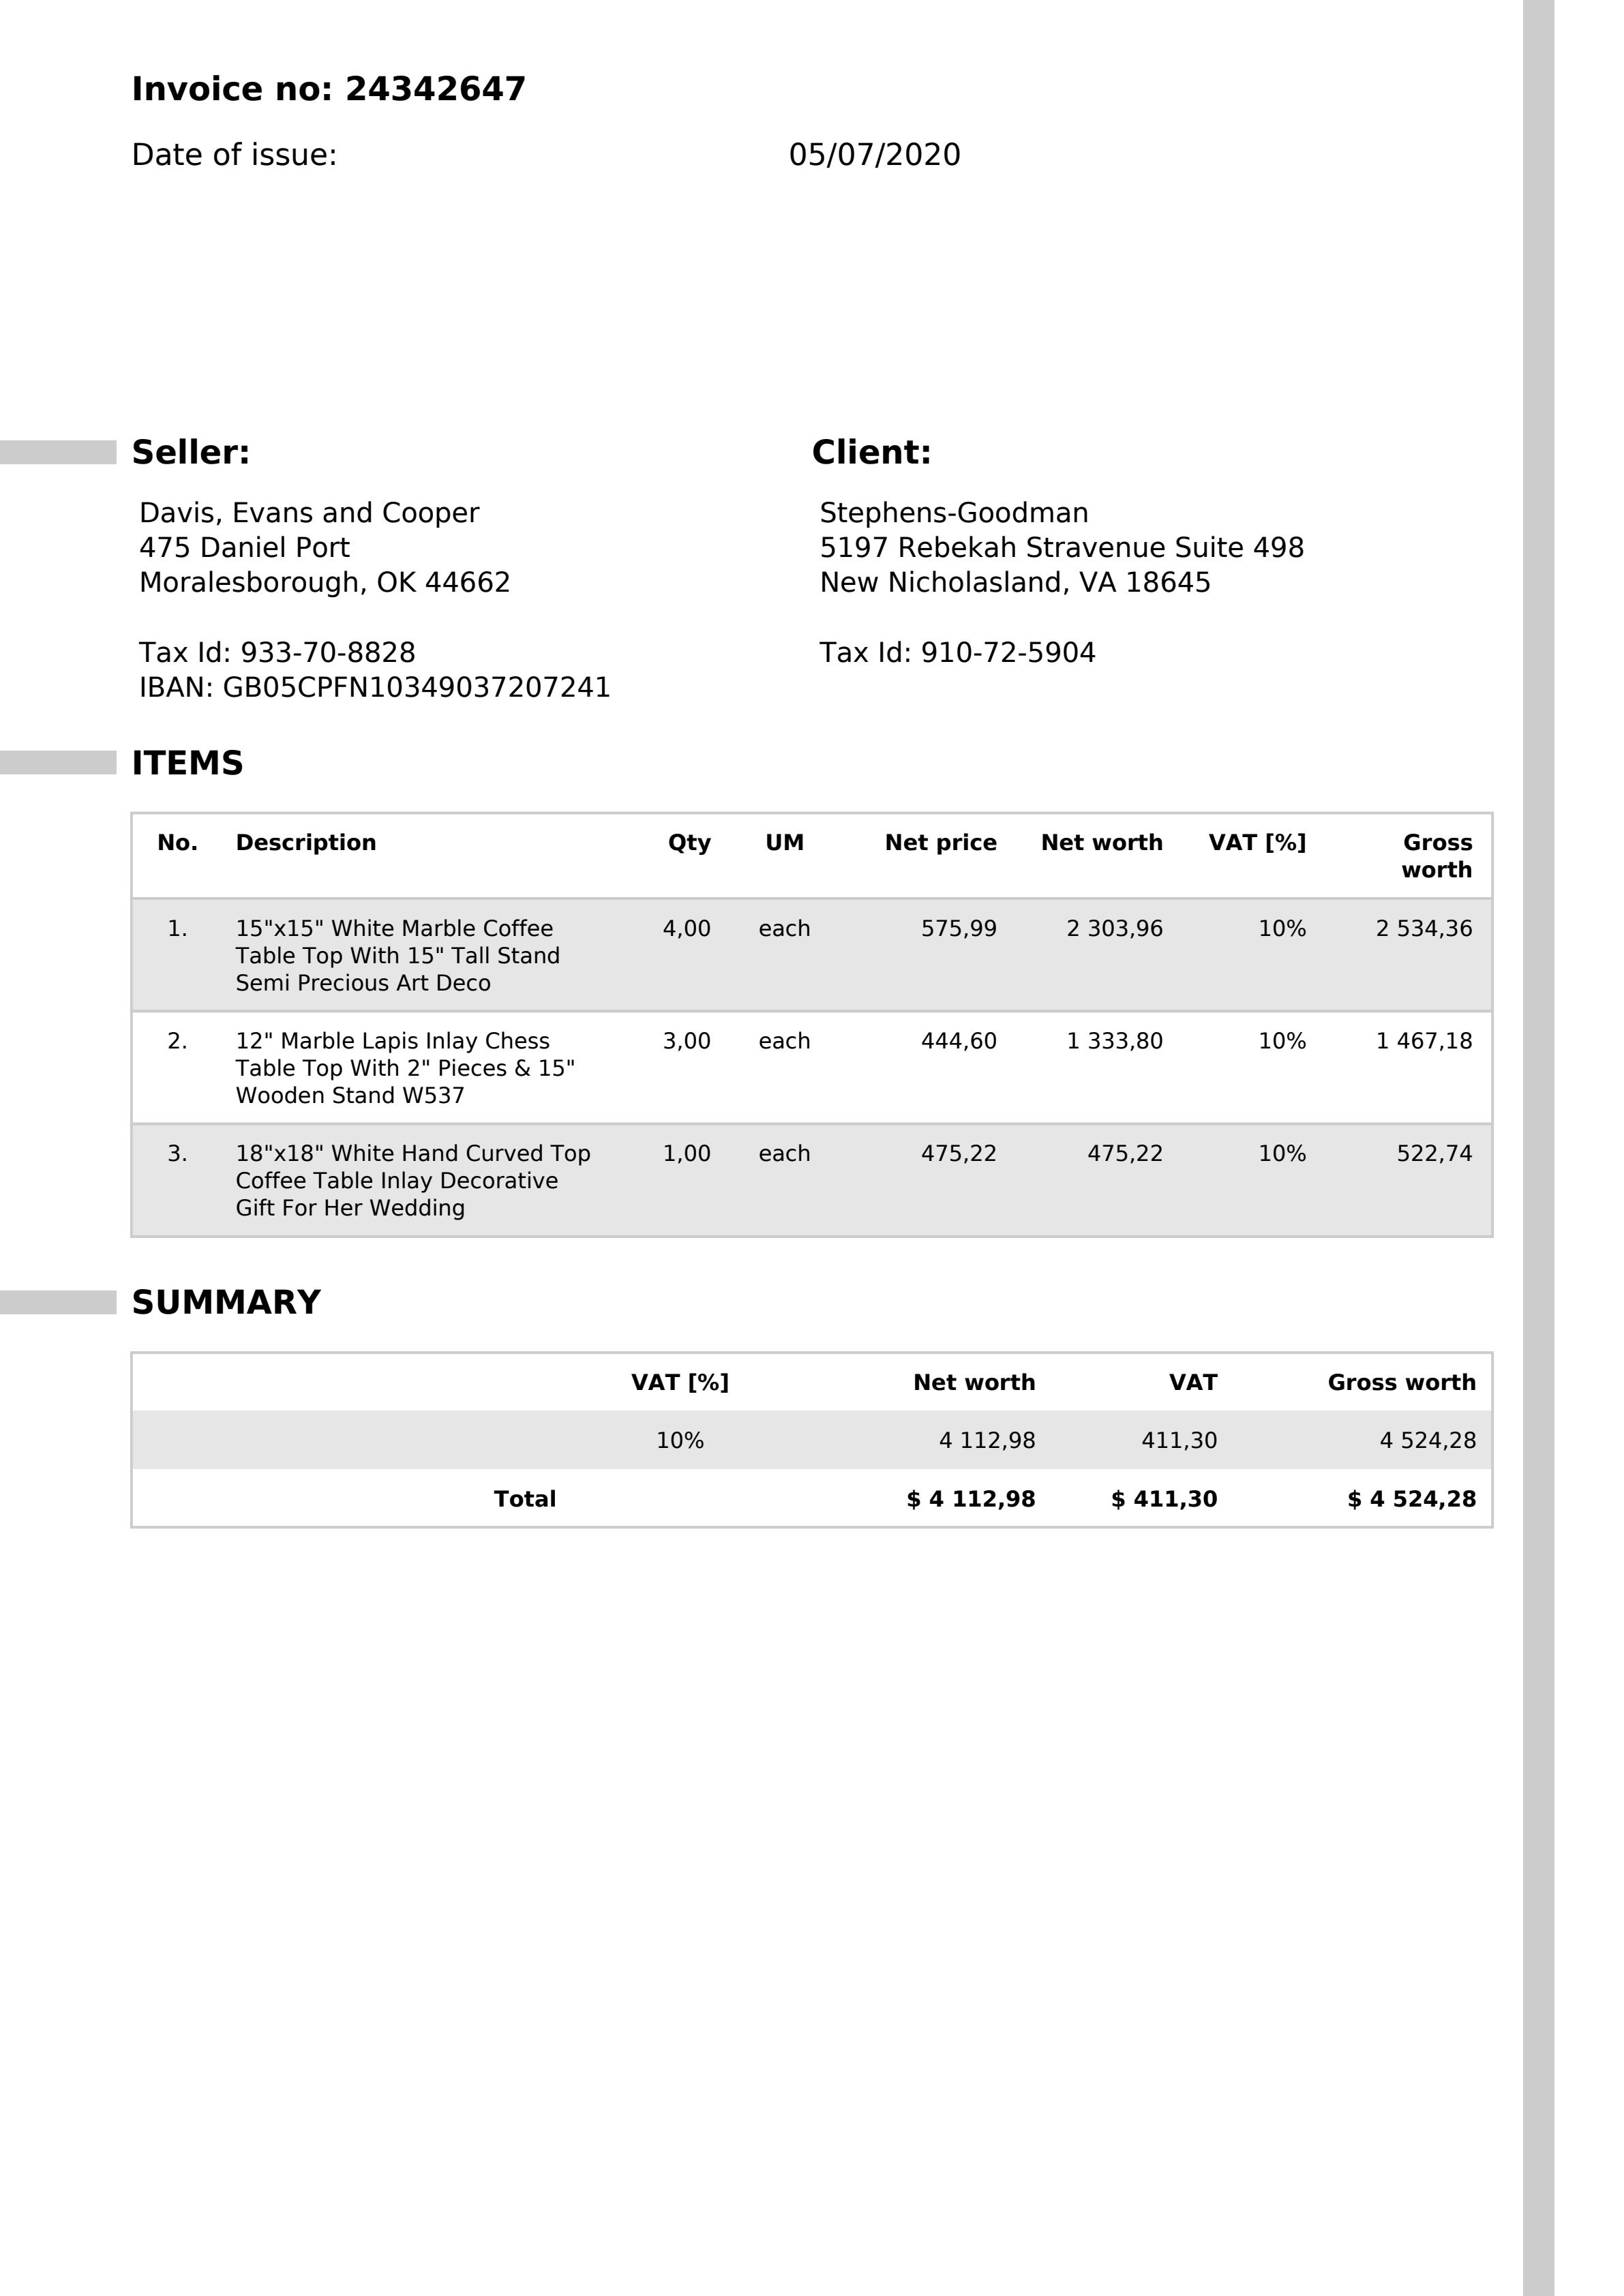

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import json
image_path = 'path to your data/data/training_data/images/invoice_5-page-1.jpg'
image = Image.open(image_path)
image

In [ ]:
import json

with open('path to your data/data/training_data/annotations/invoice_5-page-1.json') as f:
  data = json.load(f)

for annotation in data['form']:
  print(annotation)

{'text': '24342647', 'box': [498, 97, 783, 166], 'label': 'invoice_number', 'words': [{'text': '24342647', 'box': [510, 111, 769, 148]}], 'linking': [], 'id': 0}
{'text': '05/07/2020', 'box': [1150, 186, 1416, 255], 'label': 'invoice_date', 'words': [{'text': '05/07/2020', 'box': [1159, 209, 1407, 246]}], 'linking': [], 'id': 1}
{'text': 'Stephens-Goodman', 'box': [1183, 726, 1615, 775], 'label': 'client_name', 'words': [{'text': 'Stephens-Goodman', 'box': [1205, 735, 1594, 774]}], 'linking': [], 'id': 2}
{'text': '5197 Rebekah Stravenue Suite 498\nNew Nicholasland, VA 18645', 'box': [1195, 781, 1925, 878], 'label': 'client_address', 'words': [{'text': '5197', 'box': [1205, 787, 1301, 818]}, {'text': 'Rebekah', 'box': [1320, 782, 1485, 830]}, {'text': 'Stravenue', 'box': [1507, 786, 1911, 818]}, {'text': 'Suite', 'box': [1705, 782, 1825, 830]}, {'text': '498', 'box': [1829, 782, 1913, 830]}, {'text': 'New', 'box': [1206, 839, 1288, 869]}, {'text': 'Nicholasland,', 'box': [1306, 837, 15

The PIL library has a handy ImageDraw module, which -you guessed it- allows to draw things (such as rectangles) on an image:

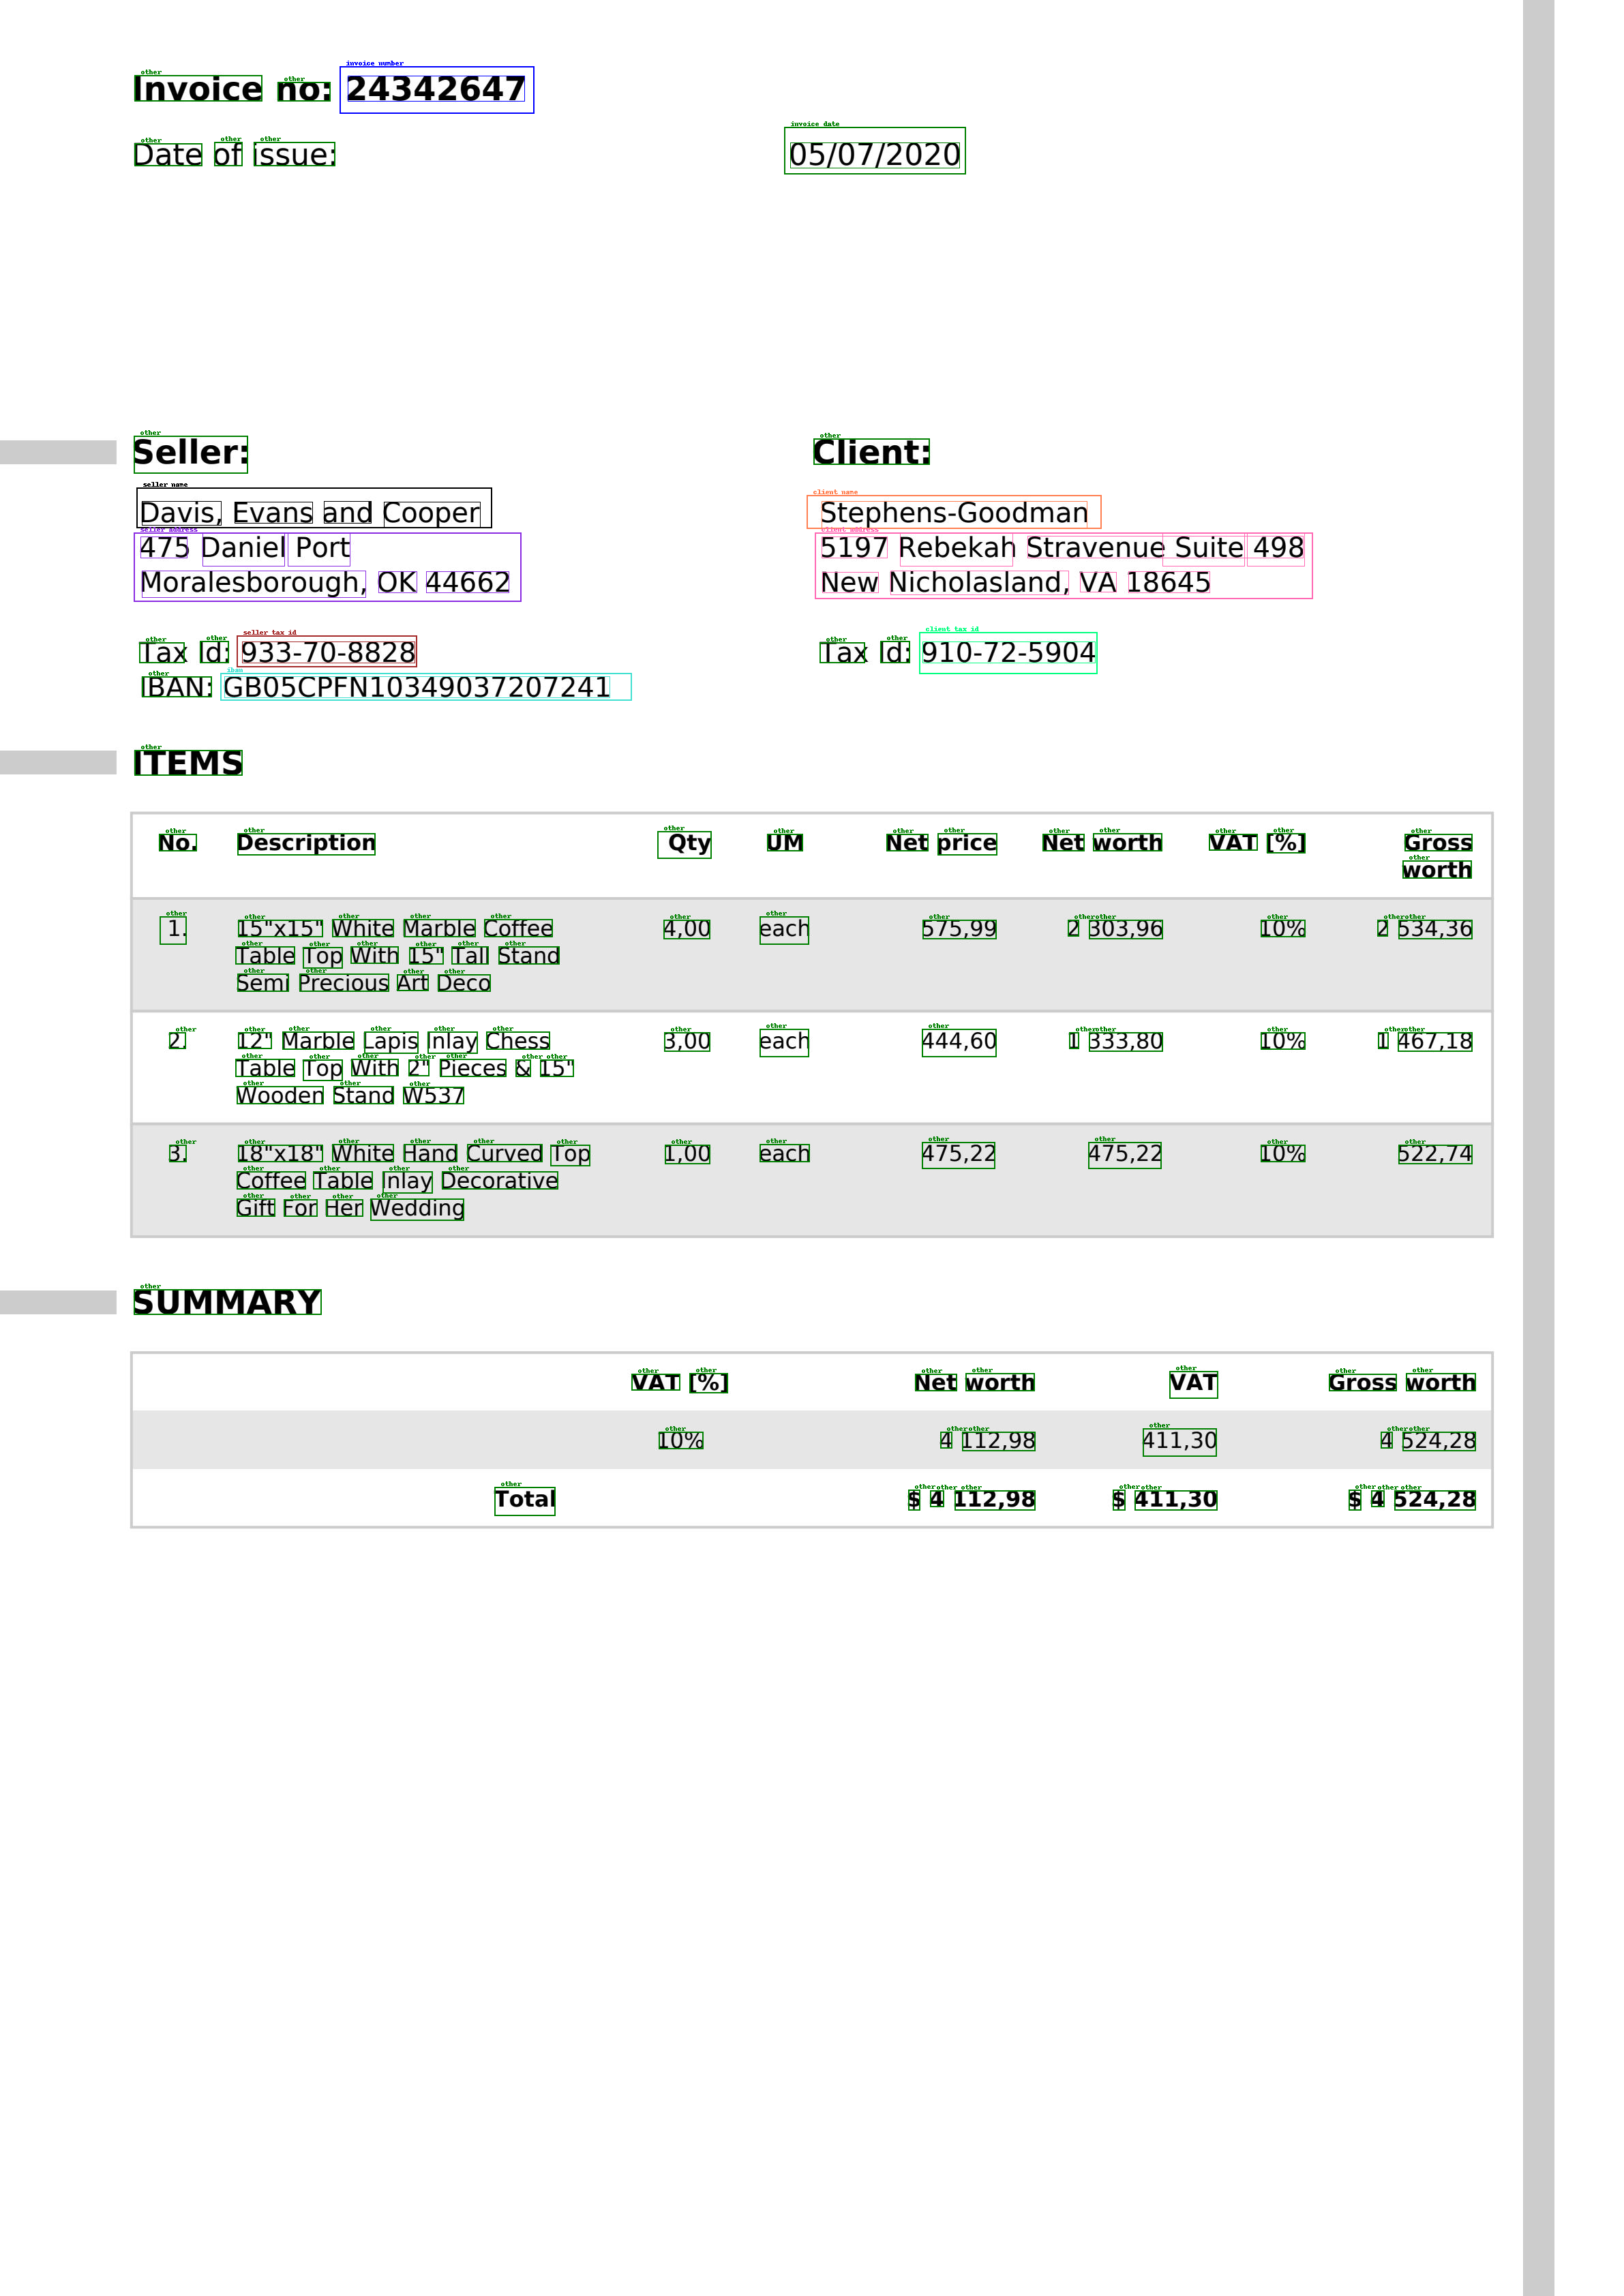

In [4]:
draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {'invoice_number':'blue', 'invoice_date':'green', 'client_name':'coral', 'client_address':'hotpink', 'client_tax_id': 'springgreen', 'seller_name': 'black', 'seller_address': 'blueviolet', 'seller_tax_id': 'brown', 'iban': 'turquoise', 'other':'green'}

for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)

image

## Preprocessing the data

Next, we need to turn the document images into individual tokens and corresponding labels (BIOES format, see further). We do this both for the training and test datasets. Make sure to run this from the `/content` directory:

In [ ]:
! python3 content/unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir path to your data/data/training_data/annotations \
                                                      --data_split train \
                                                      --output_dir path to your data/data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

! python3 content/unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir path to your data/data/testing_data/annotations \
                                                      --data_split test \
                                                      --output_dir path to your data/data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

/data/aiuserinj/sarjil/LayoutLM/content/data/train.txt.tmp
/data/aiuserinj/sarjil/LayoutLM/content/data/test.txt.tmp


Next, we create a labels.txt file that contains the unique labels of the FUNSD dataset:

In [ ]:
'''this command reads the train.txt file, extracts the second column, removes empty lines, 
sorts the labels alphabetically, removes duplicate labels, 
and saves the unique sorted labels to a file named labels.txt in the data directory.'''
! cat path to your data/data/train.txt | cut -d$'\t' -f 2 | grep -v "^$"| sort | uniq > path to your data/data/labels.txt

## Define a PyTorch dataset

First, we create a list containing the unique labels based on `data/labels.txt` (run this from the content directory):

In [ ]:
from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("path to your data/data/labels.txt")
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

We can see that the dataset uses the so-called BIOES annotation scheme to annotate the tokens. This means that a given token can be either at the beginning (B), inside (I), outside (O), at the end (E) or start (S) of a given entity. Entities include ANSWER, QUESTION, HEADER and OTHER:

In [9]:
num_labels

20

In [10]:
print(labels)

['B-CLIENT_ADDRESS', 'B-CLIENT_NAME', 'B-SELLER_ADDRESS', 'B-SELLER_NAME', 'E-CLIENT_ADDRESS', 'E-CLIENT_NAME', 'E-SELLER_ADDRESS', 'E-SELLER_NAME', 'I-CLIENT_ADDRESS', 'I-CLIENT_NAME', 'I-SELLER_ADDRESS', 'I-SELLER_NAME', 'O', 'S-CLIENT_NAME', 'S-CLIENT_TAX_ID', 'S-IBAN', 'S-INVOICE_DATE', 'S-INVOICE_NUMBER', 'S-SELLER_NAME', 'S-SELLER_TAX_ID']


Next, we can create a PyTorch dataset and corresponding dataloader (both for training and evaluation):

In [ ]:
from transformers import LayoutLMTokenizer
from content.unilm.layoutlm.layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': 'path to your data/data',
        'model_name_or_path':'microsoft/layoutlm-base-uncased',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

# the LayoutLM authors already defined a specific FunsdDataset, so we are going to use this here
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=2)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset,
                             sampler=eval_sampler,
                            batch_size=2)

/data/aiuserinj/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
len(train_dataloader)

400

In [13]:
len(eval_dataloader)

100

In [14]:
batch = next(iter(train_dataloader))
input_ids = batch[0][0]
tokenizer.decode(input_ids)

'[CLS] 30386285 09 / 28 / 2020 rodriguez and sons 126 deanna stravenue east jared, or 03244 968 - 77 - 8015 wagner - weaver 96030 berry walks apt. 416 port lancefurt, nv 06191 919 - 90 - 5010 gb85qcay53709612387596 invoice no : date of issue : seller : tax id : iban : items no. description qty 1. 40 inches marble utility table 3, 00 top inlay with royal pattern stone dinning table ds 18 " x18 " marble white table top 1, 00 lapis inlay pietradura floral home decor art gift 3. 4 pcs table feet durable high 3, 00 quality sturdy chair feet table feet for home 4. 6\'x3\'marble counter height 2, 00 dining table top multi inlay furniture decor e955a 5. 20 inches marble coffee table 1, 00 top multi stone chess board table with inlay art 6. 24 " x24 " top marble white table 2, 00 carnelian marquetry interior thanksgiving gift summary vat [ % ] 10 % total um each each each each each each client : tax id : net price 1 713, 75 1188, 45 25, 49 5 469, 38 331, 50 2 000, 00 net worth 21 676, 43 $ 21 6

## Define and fine-tune the model

As this is a sequence labeling task, we are going to load `LayoutLMForTokenClassification` (the base sized model) from the hub. We are going to fine-tune it on a downstream task, namely FUNSD.

In [15]:
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0-11): 12 x LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
 

Now we can start training:

In [16]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 5
t_total = len(train_dataloader) * num_train_epochs # total number of training steps

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  for batch in tqdm(train_dataloader, desc="Training"):
      input_ids = batch[0].to(device)
      bbox = batch[4].to(device)
      attention_mask = batch[1].to(device)
      token_type_ids = batch[2].to(device)
      labels = batch[3].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      # print loss every 100 steps
      if global_step % 100 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients
      loss.backward()

      #print("Gradients on classification head:")
      #print(model.classifier.weight.grad[6,:].sum())

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

/data/aiuserinj/.local/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:   0%|          | 0/400 [00:00<?, ?it/s]

Training:   0%|          | 1/400 [00:00<02:14,  2.96it/s]

Loss after 0 steps: 2.838618040084839


Training:  26%|██▌       | 103/400 [00:06<00:19, 15.47it/s]

Loss after 100 steps: 0.028717469424009323


Training:  51%|█████     | 203/400 [00:13<00:12, 15.43it/s]

Loss after 200 steps: 0.004782418720424175


Training:  76%|███████▌  | 303/400 [00:19<00:06, 15.42it/s]

Loss after 300 steps: 0.003620823146775365


Training:   0%|          | 2/400 [00:00<00:25, 15.71it/s]

Loss after 400 steps: 0.001966155366972089


Training:  26%|██▌       | 102/400 [00:06<00:19, 15.32it/s]

Loss after 500 steps: 0.0012946365168318152


Training:  50%|█████     | 202/400 [00:13<00:12, 15.28it/s]

Loss after 600 steps: 0.001284661702811718


Training:  76%|███████▌  | 302/400 [00:19<00:06, 15.26it/s]

Loss after 700 steps: 0.0010872948914766312


Training:   0%|          | 2/400 [00:00<00:25, 15.66it/s]

Loss after 800 steps: 0.005232751835137606


Training:  26%|██▌       | 102/400 [00:06<00:19, 15.14it/s]

Loss after 900 steps: 0.0011468776501715183


Training:  50%|█████     | 202/400 [00:13<00:13, 15.15it/s]

Loss after 1000 steps: 0.0027384376153349876


Training:  76%|███████▌  | 302/400 [00:19<00:06, 15.10it/s]

Loss after 1100 steps: 0.0005766638205386698


Training:   0%|          | 2/400 [00:00<00:26, 14.92it/s]

Loss after 1200 steps: 0.000510994519572705


Training:  26%|██▌       | 102/400 [00:06<00:19, 15.02it/s]

Loss after 1300 steps: 0.0005603539175353944


Training:  50%|█████     | 202/400 [00:13<00:13, 15.07it/s]

Loss after 1400 steps: 0.00047559503582306206


Training:  76%|███████▌  | 302/400 [00:20<00:06, 15.04it/s]

Loss after 1500 steps: 0.0005429291632026434


Training:   0%|          | 2/400 [00:00<00:25, 15.39it/s]

Loss after 1600 steps: 0.0018363489070907235


Training:  26%|██▌       | 102/400 [00:06<00:19, 15.01it/s]

Loss after 1700 steps: 0.005496426019817591


Training:  50%|█████     | 202/400 [00:13<00:13, 14.95it/s]

Loss after 1800 steps: 0.0004183002165518701


Training:  76%|███████▌  | 302/400 [00:20<00:06, 14.91it/s]

Loss after 1900 steps: 0.016233496367931366


Training: 100%|██████████| 400/400 [00:26<00:00, 14.98it/s]


## Evaluation

Now let's evaluate on the test set:

In [17]:
!pip install seqeval

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=cf64671596dac09f374ab565722ee9d13be5851db76656f441bb191c205b61cc
  Stored in directory: /data/aiuserinj/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [18]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Evaluating: 100%|██████████| 100/100 [00:01<00:00, 50.67it/s]


{'loss': 0.0028094087177305484, 'precision': 0.9983240223463687, 'recall': 0.9994407158836689, 'f1': 0.9988820570150923}


In [19]:
PATH='./sarjil_layoutlm.pt'
torch.save(model.state_dict(), PATH)

## Inference

Now comes the fun part! We can now use the fine-tuned model and test it on unseen data.

Note that LayoutLM relies on an external OCR engine (it's not end-to-end -> that's probably something for the future). The test data itself also contains the annotated bounding boxes, but let's run an OCR engine ourselves.

So let's load in a image of the test set, run our own OCR on it to get the bounding boxes, then run LayoutLM on the individual tokens and visualize the result!

Sources:
* https://www.kaggle.com/jpmiller/layoutlm-starter
* https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0

In [20]:
!git clone https://github.com/UBIAI/layout_lm_tutorial.git

Cloning into 'layout_lm_tutorial'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), done.


In [21]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libtesseract5
The following NEW packages will be installed:
  libtesseract5
The following packages will be upgraded:
  tesseract-ocr
1 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 1,722 kB of archives.
After this operation, 3,583 kB of additional disk space will be used.
Do you want to continue? [Y/n] ^C
Defaulting to user installation because normal site-packages is not writeable


In [22]:
from content.layout_lm_tutorial.layoutlm_preprocess import *
import pytesseract

In [23]:
from PIL import Image

In [ ]:
image = Image.open("path to your data/data/testing_data/images/invoice_810-page-1.jpg")
image = image.convert("RGB")
# image

In [ ]:
from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("path to your data/data/labels.txt")
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
# pad_token_label_id = CrossEntropyLoss().ignore_index

In [ ]:
model_path='/data/aiuserinj/sarjil/LayoutLM/sarjil_layoutlm.pt'
model=model_load(model_path,num_labels)
image, words, boxes, actual_boxes = preprocess("path to your data/data/testing_data/images/invoice_810-page-1.jpg")

word_level_predictions, final_boxes=convert_to_features(image, words, boxes, actual_boxes, model)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[10, 12, 12, 12, 12, 12, 17, 17, 17, 17, 12, 12, 12, 12, 12, 12, 3, 3, 3, 11, 11, 11, 7, 2, 2, 10, 10, 10, 10, 10, 10, 10, 6, 6, 10, 10, 12, 10, 19, 19, 19, 10, 10, 2, 10, 10, 10, 12, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 16, 16, 16, 16, 16, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1, 9, 9, 9, 5, 5, 0, 8, 8, 8, 8, 8, 8, 8, 4, 4, 8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1

In [27]:
invoice_labels = set([item[2:] for item in label_map.values() if len(item) > 1])

In [28]:
invoice_labels

{'CLIENT_ADDRESS',
 'CLIENT_NAME',
 'CLIENT_TAX_ID',
 'IBAN',
 'INVOICE_DATE',
 'INVOICE_NUMBER',
 'SELLER_ADDRESS',
 'SELLER_NAME',
 'SELLER_TAX_ID'}

In [29]:
final_predictions = {item: set() for item in invoice_labels}

In [30]:
final_predictions

{'SELLER_NAME': set(),
 'INVOICE_NUMBER': set(),
 'CLIENT_ADDRESS': set(),
 'CLIENT_NAME': set(),
 'SELLER_ADDRESS': set(),
 'IBAN': set(),
 'INVOICE_DATE': set(),
 'CLIENT_TAX_ID': set(),
 'SELLER_TAX_ID': set()}

In [ ]:
import pytesseract
import cv2
image_path = 'path to your data/data/testing_data/images/invoice_810-page-1.jpg'
image = cv2.imread(image_path)
# Open the image
# image = Image.open(image_path)
# draw = ImageDraw.Draw(image)
# font = ImageFont.load_default()
def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return ""
# label2color = {'invoice_number':'blue', 'invoice_date':'green', 'client_name':'coral', 'client_address':'hotpink', 'client_tax_id': 'springgreen', 'seller_name': 'black', 'seller_address': 'blueviolet', 'seller_tax_id': 'brown', 'iban': 'turquoise'}
for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(label_map[prediction]).upper()
    if predicted_label:
        x1, y1, x2, y2 = box
        # Crop image to the rectangle
        cropped_image = image[y1-10:y2+10, x1-10:x2+10]

        # Perform OCR on the cropped region
        text = pytesseract.image_to_string(cropped_image)
        
        # Print the extracted text
        if len(text)>2:
            print(predicted_label, text)
            final_predictions[predicted_label].add(text.strip('\n\x0c'))


INVOICE_NUMBER 64603610

SELLER_NAME Davila,

SELLER_NAME Davila,

SELLER_NAME Reed

SELLER_NAME and

SELLER_NAME Wright

SELLER_ADDRESS 041

SELLER_ADDRESS Faulkner

SELLER_ADDRESS Island

SELLER_ADDRESS South

SELLER_ADDRESS Feliciaview,

SELLER_ADDRESS Feliciaview,

SELLER_ADDRESS 68431

SELLER_ADDRESS Tax

SELLER_TAX_ID 983-90-3306

SELLER_TAX_ID 983-90-3306

SELLER_ADDRESS 983-90-3306

SELLER_ADDRESS 983-90-3306

SELLER_ADDRESS 983-90-3306

SELLER_ADDRESS IBAN:

IBAN GB80WHFE54430411137024

INVOICE_DATE 12/29/2013

INVOICE_DATE 12/29/2013

INVOICE_DATE 12/29/2013

INVOICE_DATE 12/29/2013

INVOICE_DATE 12/29/2013

CLIENT_NAME Moore,

CLIENT_NAME Moore,

CLIENT_NAME Guerrero

CLIENT_NAME and

CLIENT_NAME Jacobson

CLIENT_ADDRESS 730

CLIENT_ADDRESS Henderson

CLIENT_ADDRESS Ridge

CLIENT_ADDRESS Port

CLIENT_ADDRESS Michelleville,

CLIENT_ADDRESS Michelleville,

CLIENT_ADDRESS 58312



In [32]:
final_predictions

{'SELLER_NAME': {'Davila,', 'Reed', 'Wright', 'and'},
 'INVOICE_NUMBER': {'64603610'},
 'CLIENT_ADDRESS': {'58312',
  '730',
  'Henderson',
  'Michelleville,',
  'Port',
  'Ridge'},
 'CLIENT_NAME': {'Guerrero', 'Jacobson', 'Moore,', 'and'},
 'SELLER_ADDRESS': {'041',
  '68431',
  '983-90-3306',
  'Faulkner',
  'Feliciaview,',
  'IBAN:',
  'Island',
  'South',
  'Tax'},
 'IBAN': {'GB80WHFE54430411137024'},
 'INVOICE_DATE': {'12/29/2013'},
 'CLIENT_TAX_ID': set(),
 'SELLER_TAX_ID': {'983-90-3306'}}

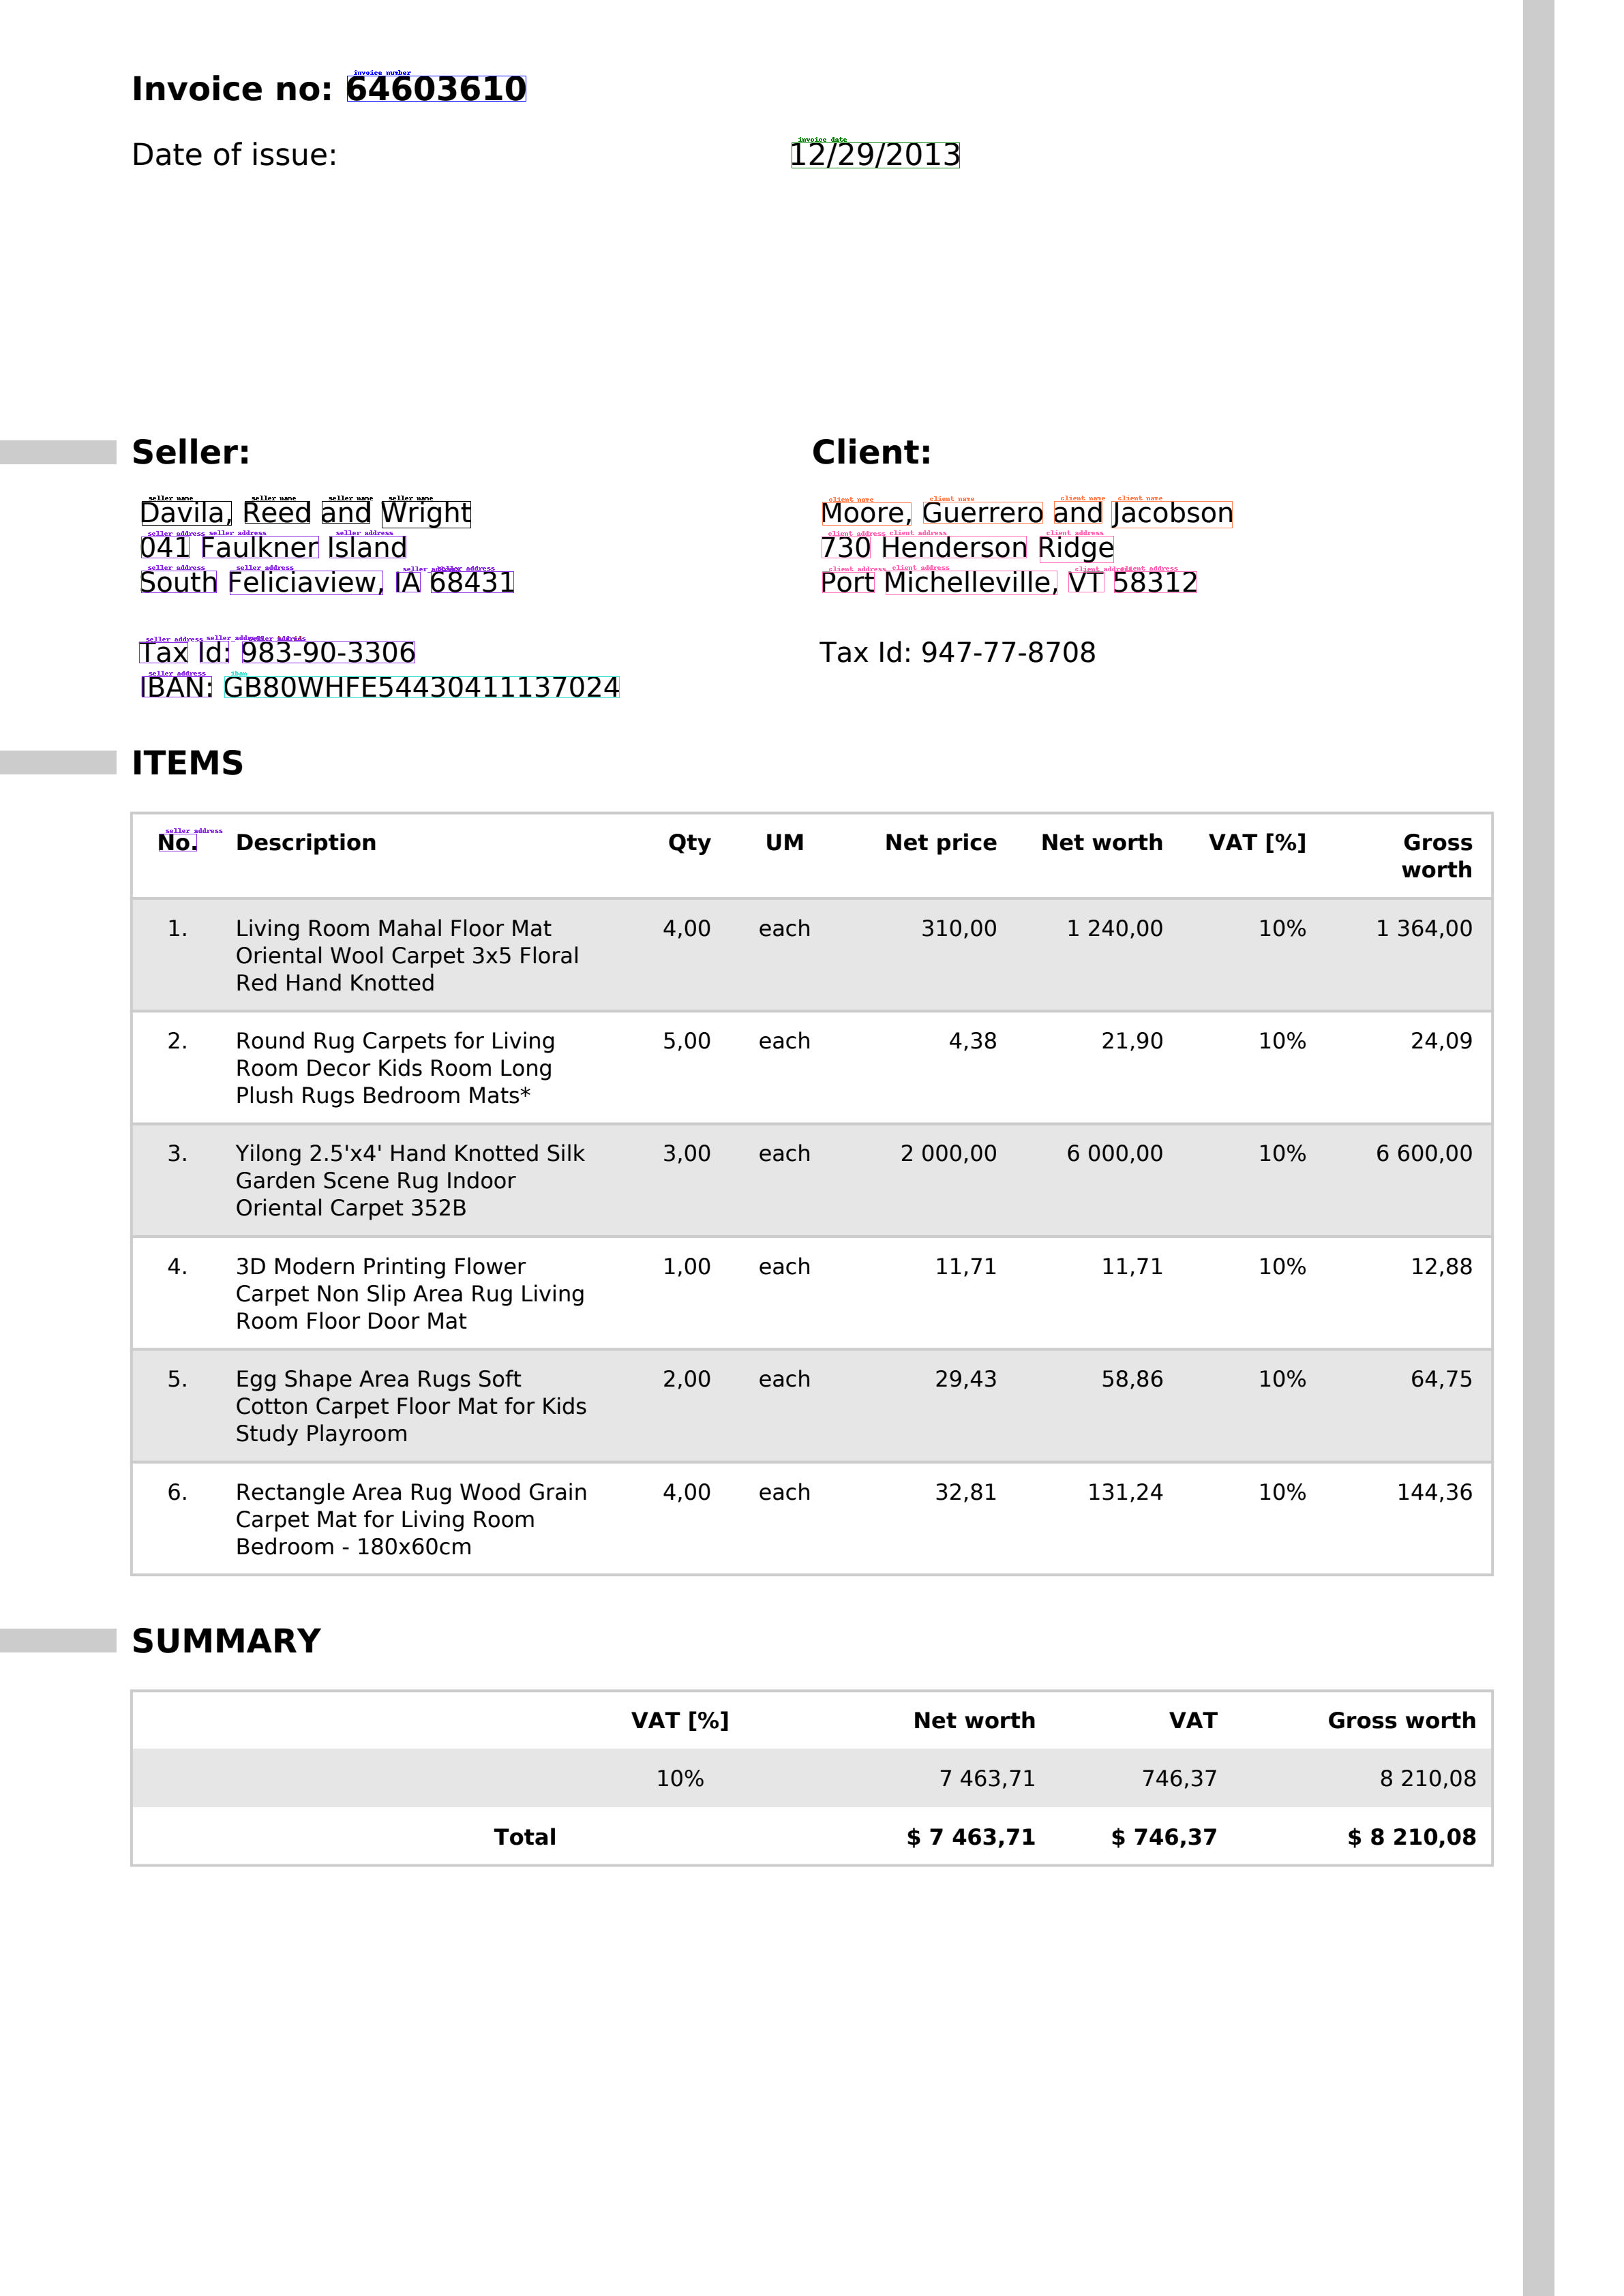

In [ ]:
image_path = 'path to your data/data/testing_data/images/invoice_810-page-1.jpg'
# Open the image
image = Image.open(image_path)
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()
def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return ""
label2color = {'invoice_number':'blue', 'invoice_date':'green', 'client_name':'coral', 'client_address':'hotpink', 'client_tax_id': 'springgreen', 'seller_name': 'black', 'seller_address': 'blueviolet', 'seller_tax_id': 'brown', 'iban': 'turquoise'}
for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(label_map[prediction]).lower()
    if predicted_label:
      draw.rectangle(box, outline=label2color[predicted_label])
      draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)
image

In [43]:
!zip -r /content/file.zip /content/

Streaming output truncated to the last 5000 lines.
  adding: content/transformers/.github/conda/meta.yaml (deflated 55%)
  adding: content/transformers/.github/PULL_REQUEST_TEMPLATE.md (deflated 52%)
  adding: content/transformers/.github/actions/ (stored 0%)
  adding: content/transformers/.github/actions/post-slack/ (stored 0%)
  adding: content/transformers/.github/actions/post-slack/action.yml (deflated 67%)
  adding: content/transformers/.github/ISSUE_TEMPLATE/ (stored 0%)
  adding: content/transformers/.github/ISSUE_TEMPLATE/feature-request.yml (deflated 56%)
  adding: content/transformers/.github/ISSUE_TEMPLATE/i18n.md (deflated 64%)
  adding: content/transformers/.github/ISSUE_TEMPLATE/bug-report.yml (deflated 61%)
  adding: content/transformers/.github/ISSUE_TEMPLATE/config.yml (deflated 48%)
  adding: content/transformers/.github/ISSUE_TEMPLATE/new-model-addition.yml (deflated 58%)
  adding: content/transformers/.github/ISSUE_TEMPLATE/migration.yml (deflated 62%)
  adding: con